In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [2]:
table = pq.read_table('../data/processed/merged_df.parquet')

In [3]:
merged_df = table.to_pandas()

In [4]:
del table

In [5]:
merged_df.head()

,499304660,499304661,499304662,499304663,499304664,499304665,499304666,499304667,499304668,499304669,...,num_tbi_w_loc,dsm_iv_clinical_diagnosis,control_set,nincds_arda_diagnosis,ever_tbi_w_loc,race,hispanic,act_demented,braak,nia_reagan
rnaseq_profile_id,,,,,,,,,,,,,,,,,,,,,
488395315,0.655725,4.526404,0.0,0.0,0.039654,0.0,0.0,0.0,0.0,0.317608,...,0,No Dementia,3,No Dementia,N,White,Not Hispanic,No Dementia,3,2
496100277,0.095143,8.855850,0.0,0.0,0.016492,0.0,0.0,0.0,0.0,0.955393,...,0,No Dementia,14,No Dementia,N,White,Not Hispanic,No Dementia,3,1
496100278,0.000000,4.868456,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.361740,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
496100279,0.000000,4.851842,0.0,0.0,0.170431,0.0,0.0,0.0,0.0,1.357990,...,2,No Dementia,2,No Dementia,Y,White,Not Hispanic,No Dementia,6,2
496100281,0.000000,3.600344,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.005507,...,0,Alzheimer's Disease Type,2,Probable Alzheimer'S Disease,N,White,Not Hispanic,Dementia,1,1


# Split Data

In [6]:
# assign X and y
X = merged_df.iloc[:,:50281]
y = merged_df['act_demented']

In [7]:
# for this model we are training only whit the hippocampus data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Standardize the data
scaler = StandardScaler()

# standarize training and test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/utils/validation.py:571: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any()):


### Dumy Model

Dummy random score: 0.39
                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     12                     23
Actual No Dementia                  23                     18
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.34      0.34      0.34        35
 No Dementia       0.44      0.44      0.44        41

    accuracy                           0.39        76
   macro avg       0.39      0.39      0.39        76
weighted avg       0.39      0.39      0.39        76



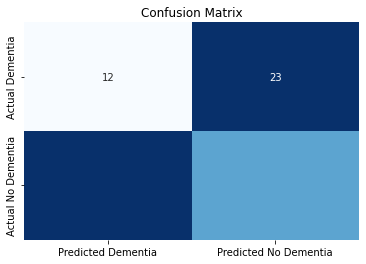

In [9]:
# Create and train a dummy model
dummy_model = DummyClassifier(random_state=42, strategy = 'stratified')
dummy_model.fit(X_train, y_train)
pred_dummy = dummy_model.predict(X_test)
dummy_score = dummy_model.score(X_test, y_test)
print("Dummy random score: {:.2f}".format(dummy_score))


conf_matrix = confusion_matrix(y_test, pred_dummy)
conf_df = pd.DataFrame(conf_matrix, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])
print(conf_df)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, pred_dummy))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.show()

### Most Frequent

Dummy most frequentscore: 0.54
                    Predicted Dementia  Predicted No Dementia
Actual Dementia                      0                     35
Actual No Dementia                   0                     41
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.00      0.00      0.00        35
 No Dementia       0.54      1.00      0.70        41

    accuracy                           0.54        76
   macro avg       0.27      0.50      0.35        76
weighted avg       0.29      0.54      0.38        76



/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

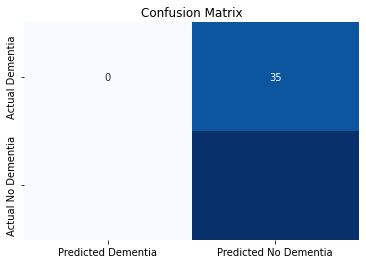

In [10]:
dummy_majority_model = DummyClassifier(random_state=42, strategy = 'most_frequent')
dummy_majority_model.fit(X_train, y_train)
pred_most_frequent = dummy_majority_model.predict(X_test)
most_frequent_score = dummy_majority_model.score(X_test, y_test)
print("Dummy most frequentscore: {:.2f}".format(most_frequent_score))

conf_matrix = confusion_matrix(y_test, pred_most_frequent)
conf_df = pd.DataFrame(conf_matrix, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])

print(conf_df)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, pred_most_frequent))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.show()

### Logistic Regression Model

Logistic regression: 0.79
                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     24                     11
Actual No Dementia                   5                     36
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.83      0.69      0.75        35
 No Dementia       0.77      0.88      0.82        41

    accuracy                           0.79        76
   macro avg       0.80      0.78      0.78        76
weighted avg       0.79      0.79      0.79        76



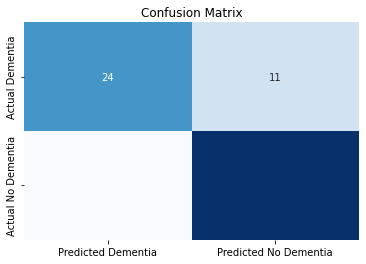

In [11]:
# Create and train the logistic regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)
pred_logreg = logreg_model.predict(X_test)
logreg_score = logreg_model.score(X_test, y_test)
print("Logistic regression: {:.2f}".format(logreg_score))

conf_matrix = confusion_matrix(y_test, pred_logreg)
conf_df = pd.DataFrame(conf_matrix, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])

print(conf_df)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, pred_logreg))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.show()

### Support Vector Machines (SVM)

SVM: 0.79
                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     24                     11
Actual No Dementia                   5                     36
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.83      0.69      0.75        35
 No Dementia       0.77      0.88      0.82        41

    accuracy                           0.79        76
   macro avg       0.80      0.78      0.78        76
weighted avg       0.79      0.79      0.79        76



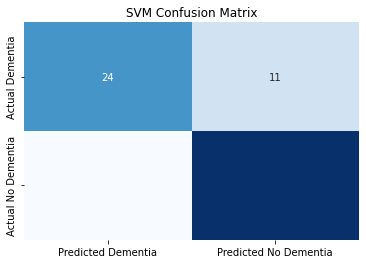

In [12]:
# Create and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
pred_svm = svm_model.predict(X_test)
svm_score = svm_model.score(X_test, y_test)
print("SVM: {:.2f}".format(svm_score))

# Confusion matrix
conf_matrix_svm = confusion_matrix(y_test, pred_svm)
conf_df_svm = pd.DataFrame(conf_matrix_svm, index=['Actual Dementia', 'Actual No Dementia'],
                            columns=['Predicted Dementia', 'Predicted No Dementia'])

print(conf_df_svm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, pred_svm))

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_df_svm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("SVM Confusion Matrix")
plt.show()

### Decision Tree

Decision tree: 0.64
                    Predicted Dementia  Predicted No Dementia
Actual Dementia                     19                     16
Actual No Dementia                  11                     30
Classification Report:
              precision    recall  f1-score   support

    Dementia       0.63      0.54      0.58        35
 No Dementia       0.65      0.73      0.69        41

    accuracy                           0.64        76
   macro avg       0.64      0.64      0.64        76
weighted avg       0.64      0.64      0.64        76



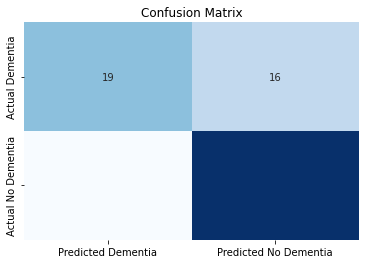

In [13]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
pred_tree = tree_model.predict(X_test)
tree_score = tree_model.score(X_test, y_test)
print("Decision tree: {:.2f}".format(tree_score))

conf_matrix = confusion_matrix(y_test, pred_tree)
conf_df = pd.DataFrame(conf_matrix, index=['Actual Dementia', 'Actual No Dementia'],
                       columns=['Predicted Dementia', 'Predicted No Dementia'])
print(conf_df)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test, pred_tree))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.show()

### Discussion

In order to compare and evaluate models performace we first created two separet models to serve as a basline form comparisons. The first model randomly predicts classes based on the dirstributiom of the target variable. The second model that always predicts the majority class. We them proceded to create two additianl advanced models a logistic regresion model and a decision tree model.

__Dummy Model with Random Predictions:__

Accuracy: 39%
The model's random predictions resulted in poor performance, as indicated by the low accuracy.
The precision, recall, and F1-score for both classes (Dementia and No Dementia) are relatively balanced, but all metrics are low.
This dummy model serves as a baseline, and any advanced model should outperform it significantly.

__Dummy Model with Majority Predictions:__

Accuracy: 54%
The model achieved better accuracy than the random dummy model by always predicting the majority class (No Dementia).
However, the precision, recall, and F1-score for the minority class (Dementia) are zero, indicating that the model failed to identify cases of dementia.
This model highlights the importance of considering class imbalances and choosing appropriate evaluation metrics.  

__Logistic Regression:__

Accuracy: 83%
Logistic regression demonstrated superior performance compared to both dummy models.
The model achieved high precision, recall, and F1-score for both classes, indicating a good balance between correctly identifying positive and negative cases.
The high accuracy suggests that logistic regression effectively captured the underlying patterns in the data, making it a strong candidate for the chosen task.  

__Decision Tree:__

Accuracy: 66%
The decision tree model showed competitive performance but fell short of logistic regression.
Precision, recall, and F1-score for both classes are reasonably balanced, but slightly lower than logistic regression.
Decision trees, while effective, may be more prone to overfitting and might not generalize as well as logistic regression on unseen data.  

In conclusion the logistic regression looks to be the most suitable model for predicting dementia. This model outperformed both dummy models and the decision tree in terms of accuracy and balanced performance metrics.
The strong performance of logistic regression suggests that the linear relationships captured by this model are effective for distinguishing between dementia and non-dementia cases in the dataset.  

Next steps may include hyperparameter tuning, cross-validation, and exploration of more complex models to optimize performance, but logistic regression provides a solid baseline for comparison and interpretation. We want to explore oportunities False possitives and False negatives.

In [14]:
# Get decision function scores
decision_scores = logreg_model.decision_function(X_test)
decision_scores

array([ 5.07931902e+00,  4.87819969e+00, -4.45064560e+00, -6.94769080e+00,
       -2.06905421e+00,  1.53032355e+00, -5.19898217e+00, -2.26036320e+01,
        5.98769288e-01,  1.29221985e+00,  3.78122274e+00,  1.20985014e+00,
        9.98035047e+00, -1.84957006e+00,  2.70451087e+00, -5.46969902e+00,
       -1.78798684e-01,  2.80801422e-01,  5.88540479e+00,  5.50842001e+00,
       -6.23827432e+00, -9.07249360e-01, -5.54224968e+00,  7.51778018e+00,
       -3.98839678e+00,  2.21070724e+00,  6.15195225e-01, -4.58484909e+00,
        1.78210149e-01,  1.02619824e+01,  4.65816299e+00,  2.37442640e+00,
       -4.48822893e+00, -1.85139731e+00,  3.50150242e+00, -4.69342856e-01,
        1.65034209e+00,  5.71003043e+00,  2.88078453e+00,  3.73927248e+00,
       -4.19152382e-01, -8.04284981e-01,  4.69003753e+00,  4.65804849e+00,
        4.84424113e+00,  3.96454258e+00, -5.95454707e+00,  1.04851507e+01,
        1.76666081e+00,  1.04720258e+00,  2.48572379e+00,  8.33259484e+00,
        2.83865858e-01,  

In [15]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Convert 'Dementia' to 1 and 'No Dementia' to 0
y_true_binary = np.where(y_test == 'Dementia', 1, 0)
y_scores = np.where(pred_logreg == 'Dementia', 1, 0)

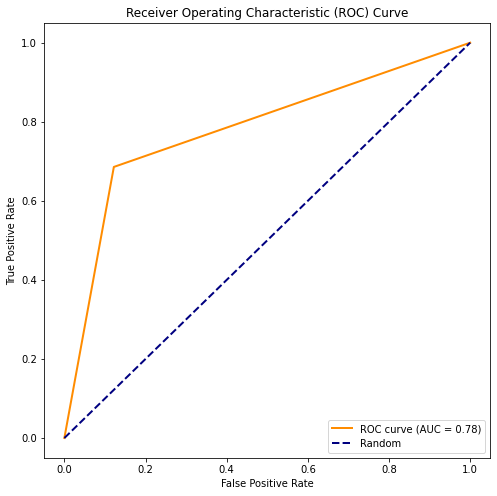

In [16]:
fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In the above ROC curve, the AUC is approximately 0.86, which suggesting good discriminatory ability of the model.
The curve is inclined towards the top-left corner, which indicats a good balance between true positive rate and false positive rate.
You can also see the the model performs better than random guessing (AUC = 0.5).

<font color="red" size="24">END OF NOTEBOOK</font>